# Multi-Modal Data Fusion - Project Work: Multi-Modal Physical Exercise Classification


In this project, real multi-modal data is studied by utilizing different techniques presented during the course. In addition, there is an optional task to try some different approaches to identify persons from the same dataset. Open MEx dataset from UCI machine learning repository is used. Idea is to apply different techniques to recognize physical exercises from wearable sensors and depth camera, user-independently.

## Author(s)
Add your information here

Name : Athmajan Vivekananthan

Student number: 2305573

## Description 

The goal of this project is to develop user-independent pre-processing and classification models to recognize 7 different physical exercises measured by accelerometer (attached to subject's thigh) and depth camera (above the subject facing downwards recording an aerial view). All the exercises were performed subject lying down on the mat. Original dataset have also another acceleration sensor and pressure-sensitive mat, but those two modalities are ommited in this project. There are totally 30 subjects in the original dataset, and in this work subset of 10 person is utilized. Detailed description of the dataset and original data can be access in [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#). We are providing the subset of dataset in Moodle.

The project work is divided on following phases:

1. Data preparation, exploration, and visualization
2. Feature extraction and unimodal fusion for classification
3. Feature extraction and feature-level fusion for multimodal classification
4. Decision-level fusion for multimodal classification
5. Bonus task: Multimodal biometric identification of persons

where 1-4 are compulsory (max. 10 points each), and 5 is optional to get bonus points (max. 5+5 points). In each phase, you should visualize and analyse the results and document the work and findings properly by text blocks and figures between the code. <b> Nice looking </b> and <b> informative </b> notebook representing your results and analysis will be part of the grading in addition to actual implementation.

The results are validated using confusion matrices and F1 scores. F1 macro score is given as 
<br>
<br>
$
\begin{equation}
F1_{macro} = \frac{1}{N} \sum_i^N F1_i,
\end{equation}
$
<br>
<br>
where $F1_i = 2  \frac{precision_i * recall_i}{precision_i + recall_i}$, and $N$ is the number of classes.
<br>

## Learning goals 

After the project work, you should  

- be able to study real world multi-modal data
- be able to apply different data fusion techniques to real-world problem
- be able to evaluate the results
- be able to analyse the outcome
- be able to document your work properly

## Relevant lectures

Lectures 1-8

## Relevant exercises

Exercises 0-6

## Relevant chapters in course book

Chapter 1-14

## Additional Material 

* Original dataset [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#)
* Related scientific article [MEx: Multi-modal Exercises Dataset for Human Activity Recognition](https://arxiv.org/pdf/1908.08992.pdf)

# 1. Data preparation, exploration, and visualization

<a id='task1'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 1.</b>

Download data from the Moodle's Project section. Get yourself familiar with the folder structure and data. You can read the data files using the function given below. Each file consists one exercise type performed by single user. Data are divided on multiple folders. Note that, in each folder there is one long sequence of single exercise, except exercise 4 which is performed two times in different ways. Those two sequences belongs to same class. Do the following subtasks to pre-analyse data examples and to prepare the training and testing data for next tasks:
<br>
<br> 
<p> Read raw data from the files. Prepare and divide each data file to shorter sequences using windowing method. Similar to related article "MEx: Multi-modal Exercises Dataset for Human Activity Recognition", use 5 second window and 3 second overlapping between windows, producing several example sequences from one exercise file for classification purposes. Windowing is working so that starting from the beginning of each long exercise sequence, take 5 seconds of data points (from synchronized acceleration data and depth images) based on the time stamps. Next, move the window 2 seconds forward and take another 5 seconds of data. Then continue this until your are at the end of sequence. Each window will consists 500x3 matrix of acceleration data and 5x192 matrix of depth image data.</p>

</div>

In [297]:
# Import relevant libraries here
from pathlib import Path
from copy import deepcopy
import numpy as np
import pandas as pd
import seaborn as sns

# Enter data folder location
loc = "./MEx"

In [298]:
"""
    IMPORTANT: PLEASE DO NOT MODIFY THE CODE IN THIS CELL.
"""
def path_to_meta(p):
    meta = dict()
    meta["subject_id"] = p.parent.stem
    meta["exercise_id"] = p.stem.split("_")[-2]
    meta["trial"] = int(p.stem.split("_")[-1])
    meta["sensor_code"] = p.stem.split("_")[0]
    meta["sensor"] = {"act": "acc", "dc": "dc"}[meta["sensor_code"]]
    return meta

# Find, read, and compose the measurements
paths_record = Path(loc).glob("*/*/*.csv")

records = []

for path_record in paths_record:
    df = pd.read_csv(path_record, delimiter=",", header=None)
    meta = path_to_meta(path_record)
    
    if meta["sensor"] == "acc":
        col_names = ["time", "acc_0", "acc_1", "acc_2"]
        df.columns = col_names
    else:
        num_cols = df.shape[1]
        col_names = ["time", ] + [f"dc_{i}" for i in range(num_cols-1)]
        df.columns = col_names

    meta["df"] = df
    
    records.append(meta)

df_records = pd.DataFrame.from_records(records)

print(f"Total records found: {len(df_records)}")
print("Dataframe with all records:")
display(df_records.head())
print("Dataframe with one measurement series:")
display(df_records["df"].iloc[0].head())

Total records found: 160
Dataframe with all records:


,subject_id,exercise_id,trial,sensor_code,sensor,df
0,03,02,1,act,acc,time acc_0 acc_1 acc_2 0 ...
1,03,04,2,act,acc,time acc_0 acc_1 acc_2 0 ...
2,03,06,1,act,acc,time acc_0 acc_1 acc_2 0 ...
3,03,04,1,act,acc,time acc_0 acc_1 acc_2 0 ...
4,03,03,1,act,acc,time acc_0 acc_1 acc_2 0 ...


Dataframe with one measurement series:


,time,acc_0,acc_1,acc_2
0,0.0,-0.765625,0.484375,-0.375000
1,10.0,-0.765625,0.493750,-0.365625
2,20.0,-0.765625,0.490625,-0.368750
3,30.0,-0.765625,0.494792,-0.364583
4,40.0,-0.765625,0.489063,-0.370312


In [3]:
dfDCAth = df_records[df_records["sensor"]=="dc"]
dfDCAth
#display(df_records["df"].iloc[80].head())

,subject_id,exercise_id,trial,sensor_code,sensor,df
80,03,07,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...
81,03,05,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...
82,03,01,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...
83,03,03,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...
84,03,04,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...
...,...,...,...,...,...,...
155,06,01,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...
156,06,04,2,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...
157,06,06,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...
158,06,04,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...


In [299]:
"""
    IMPORTANT: PLEASE DO NOT MODIFY THE CODE IN THIS CELL.
"""

# Extract 5-second long windows with 2-second shift (3-second overlap)

records_windowed = []

time_window = 5000.
time_offset = 2000.
    
for row_idx, row_data in df_records.iterrows():
    df_tmp = row_data["df"]
    time_start = np.min(df_tmp["time"].to_numpy())
    time_end = np.max(df_tmp["time"].to_numpy())
    
    for window_idx, t0 in enumerate(np.arange(time_start, time_end, time_offset)):
        t1 = t0 + time_window
        # Handle boundary conditions - skip the measurements from the end shorter than window size
        if t1 > time_end:
            continue
        
        tmp_data = deepcopy(row_data)
        tmp_data["window_idx"] = window_idx
        tmp_data["df"] = df_tmp[(df_tmp["time"] >= t0) &
                                (df_tmp["time"] < t1)].copy()
        
        records_windowed.append(tmp_data)
        
df_records_windowed = pd.DataFrame.from_records(records_windowed)

print(f"Total windows extracted: {len(df_records_windowed)}")
print("Dataframe with all windowed records:")
display(df_records_windowed.head())
print("Dataframe with one windowed measurement series:")
display(df_records_windowed["df"].iloc[0].head())

Total windows extracted: 4169
Dataframe with all windowed records:


,subject_id,exercise_id,trial,sensor_code,sensor,df,window_idx
0,03,02,1,act,acc,time acc_0 acc_1 acc_2 0 ...,0
1,03,02,1,act,acc,time acc_0 acc_1 acc_2 200 ...,1
2,03,02,1,act,acc,time acc_0 acc_1 acc_2 400 ...,2
3,03,02,1,act,acc,time acc_0 acc_1 acc_2 60...,3
4,03,02,1,act,acc,time acc_0 acc_1 acc_2 80...,4


Dataframe with one windowed measurement series:


,time,acc_0,acc_1,acc_2
0,0.0,-0.765625,0.484375,-0.375000
1,10.0,-0.765625,0.493750,-0.365625
2,20.0,-0.765625,0.490625,-0.368750
3,30.0,-0.765625,0.494792,-0.364583
4,40.0,-0.765625,0.489063,-0.370312


<a id='task1'></a>
<div class=" alert alert-warning">
     
<p> <b>1.1</b> Plot few examples of prepared data for each modalities (accelometer and depth camera). Plot acceleration sensor as multi-dimensional time-series and depth camera data as 2D image. Plot 5 second acceleration sensor and depth image sequences of person 1 and 5 performing exercises 2, 5, and 6. Take the first windowed example from the long exercise sequence. </p>

</div>

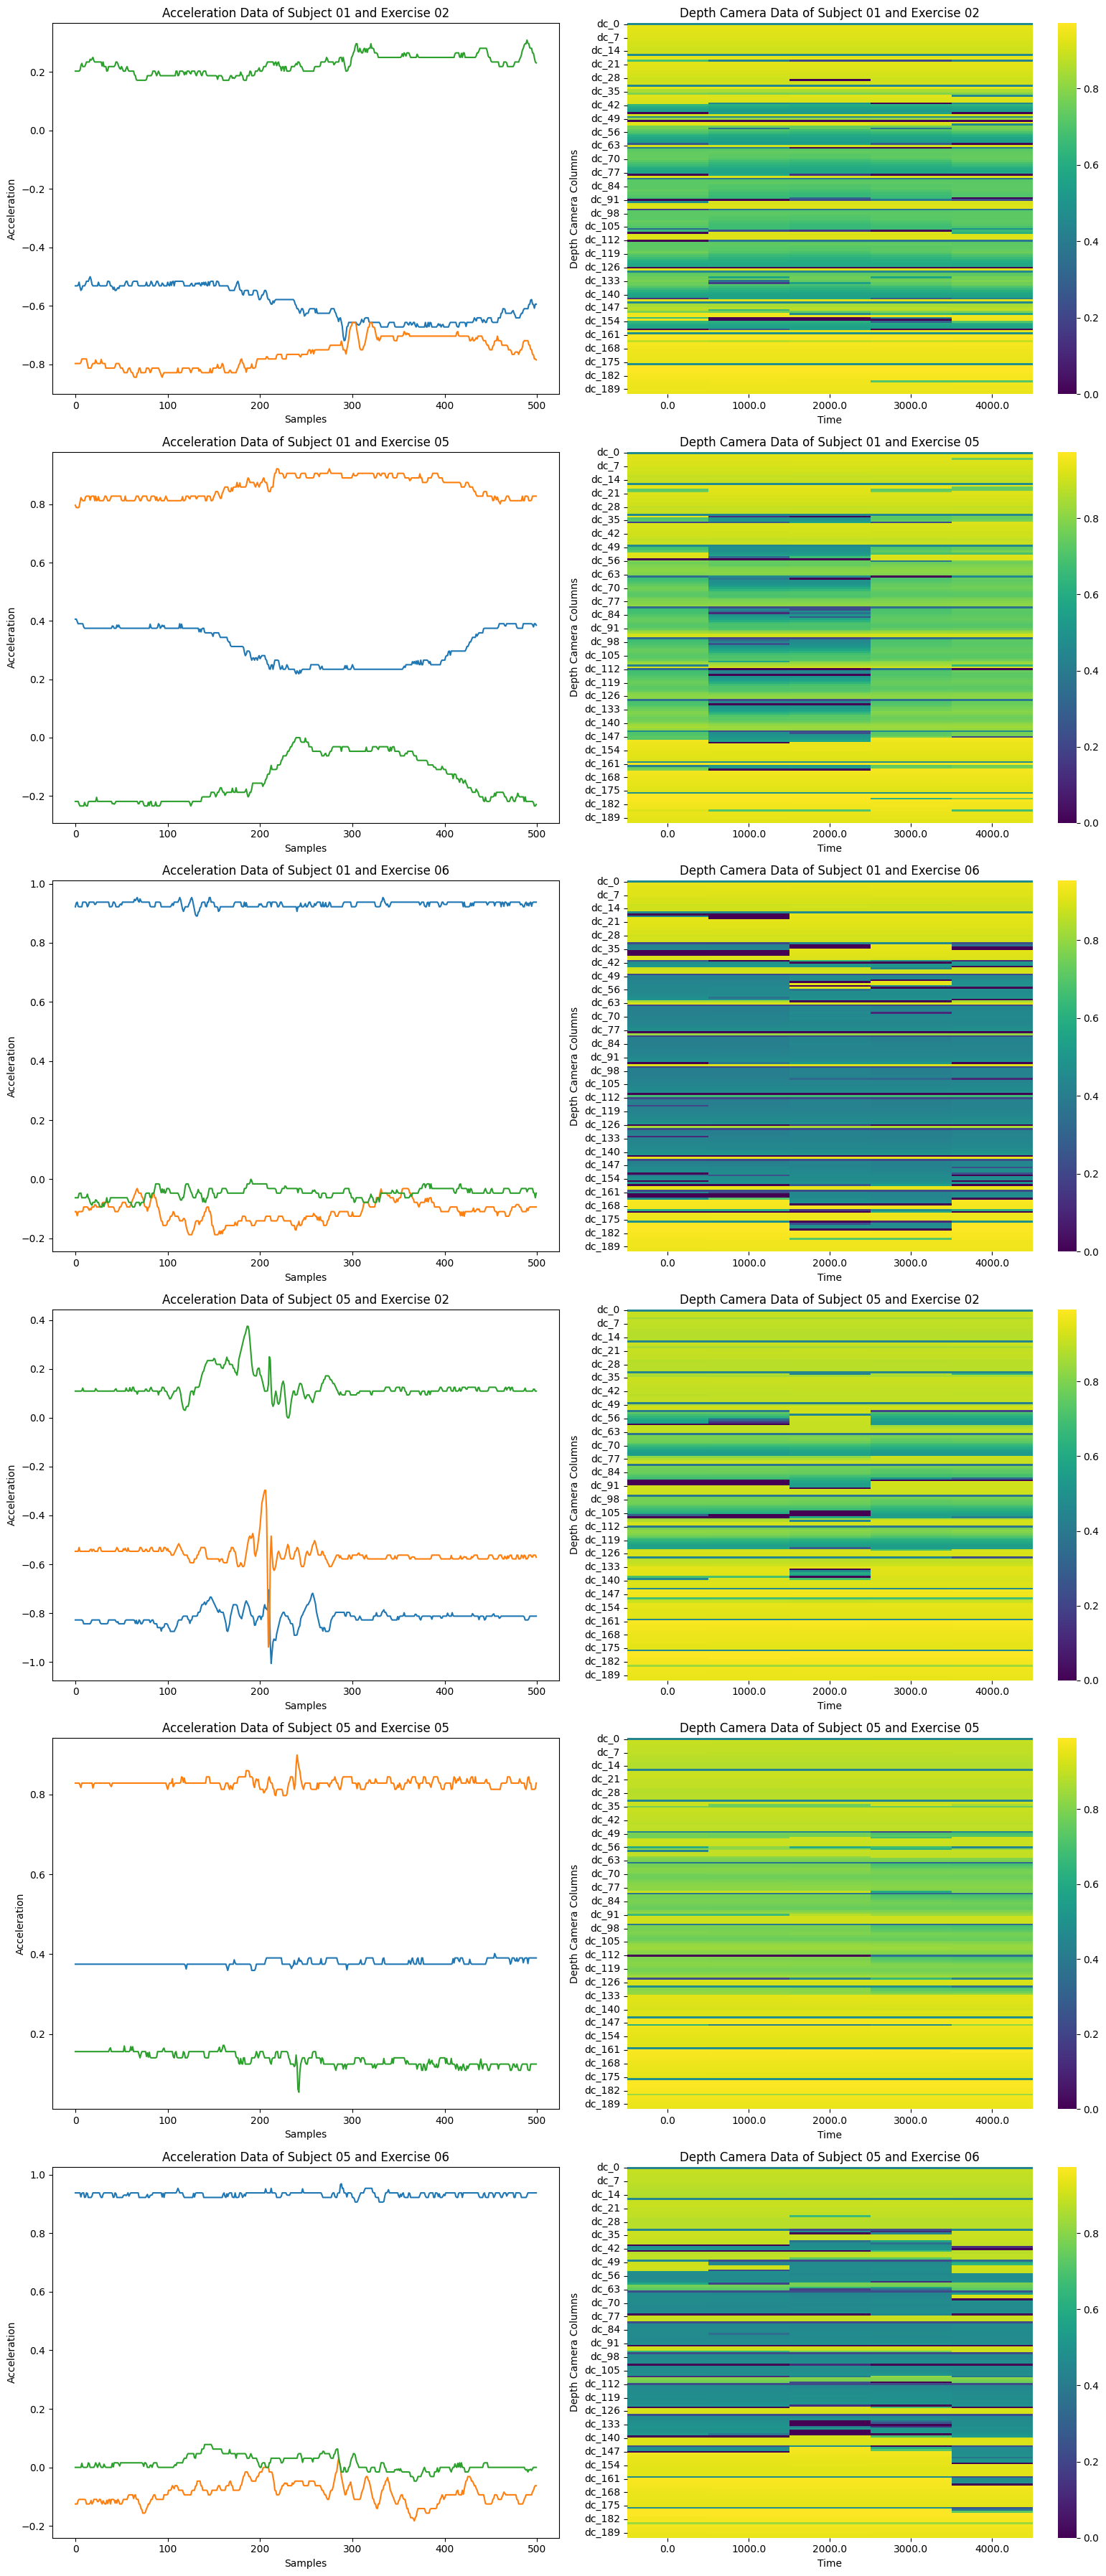

In [300]:
# 1.1. Visualize selected samples for both modalities
### Your code begins here ###

import matplotlib.pyplot as plt
import seaborn as sns

def retrieveSequence(df_records_windowed,subjectID,exID,windowID):
    dfOut1 = df_records_windowed[(df_records_windowed["subject_id"] == subjectID) & (df_records_windowed["exercise_id"] == exID)]
    dfOut2 = dfOut1[(dfOut1["window_idx"] == windowID)]
    dfDC = dfOut2[dfOut2["sensor"]=="dc"]["df"].iloc[0]
    dfAcc = dfOut2[dfOut2["sensor"]=="acc"]["df"].iloc[0]
    
    return dfAcc,dfDC


def drawplots(df_records_windowed,subjectID,exID,windowID,row):
    df_acceleration,df_depth = retrieveSequence(df_records_windowed,subjectID,exID,windowID)
    
    axs[row,0].plot(df_acceleration['acc_0'])
    axs[row,0].plot(df_acceleration['acc_1'])
    axs[row,0].plot(df_acceleration['acc_2'])
    axs[row,0].set_xlabel('Samples')
    axs[row,0].set_ylabel('Acceleration')
    axs[row,0].set_title('Acceleration Data of Subject '+subjectID+" and Exercise "+ exID)


    sns.heatmap(df_depth.set_index('time').T, cmap='viridis',ax=axs[row,1])
    axs[row,1].set_title('Depth Camera Data of Subject '+subjectID+" and Exercise "+ exID)
    axs[row,1].set_xlabel('Time')
    axs[row,1].set_ylabel('Depth Camera Columns')
        
    return

fig, axs = plt.subplots(6, 2, figsize=(16, 6*6))
drawplots(df_records_windowed,"01","02",0,0)
drawplots(df_records_windowed,"01","05",0,1)
drawplots(df_records_windowed,"01","06",0,2)
drawplots(df_records_windowed,"05","02",0,3)
drawplots(df_records_windowed,"05","05",0,4)
drawplots(df_records_windowed,"05","06",0,5)
plt.tight_layout()
plt.show()

### Your code ends here ###

<a id='task1'></a>
<div class=" alert alert-warning">

<p> <b>1.2</b> Split the prepared dataset to training and testing datasets so that data of persons 1-7 are used for training and data of persons 8-10 are used for testing. In next tasks, training dataset could be further divided on (multiple) validation data folds to tune the models parameters, when needed.<br>
    
<p> Note: Training set should have 1486 windows and testing set should have 598 windows. In training set, acceleration data will have a window without a pair with depth camera data, that window should be dropped as it doesn't have a pair.<p>
  
Document your work, calculate the indicator statistics of training and testing datasets (number of examples, dimensions of each example) and visualize prepared examples.

</div>

In [301]:
# 1.2. Split samples based on subject ID into training and testing datasets for futher experiments

trainingPersons = ["01", "02", "03", "04", "05", "06", "07"]
testingPersons = ["08", "09", "10"]

dfTraining_Acc = df_records_windowed[(df_records_windowed["subject_id"].isin(trainingPersons)) & (df_records_windowed["sensor"]=="acc")]
dfTraining_DC = df_records_windowed[(df_records_windowed["subject_id"].isin(trainingPersons)) & (df_records_windowed["sensor"]=="dc")]
dfTesting_Acc = df_records_windowed[(df_records_windowed["subject_id"].isin(testingPersons)) & (df_records_windowed["sensor"]=="acc")]
dfTesting_DC = df_records_windowed[(df_records_windowed["subject_id"].isin(testingPersons)) & (df_records_windowed["sensor"]=="dc")]

merged_Training = pd.merge(dfTraining_Acc, dfTraining_DC, on=['subject_id','exercise_id','trial','window_idx'],how="inner")
merged_Training = merged_Training[['subject_id','exercise_id','trial','window_idx','df_x','df_y']]
merged_Testing = pd.merge(dfTesting_Acc, dfTesting_DC, on=['subject_id', 'exercise_id','trial','window_idx'],how="inner")
merged_Testing = merged_Testing[['subject_id','exercise_id','trial','window_idx','df_x','df_y']]

merged_Training.columns = ['subject_id','exercise_id','trial','window_idx','df_Acc','df_Dc']
merged_Testing.columns = ['subject_id','exercise_id','trial','window_idx','df_Acc','df_Dc']


# Drop windows without a pair in training set
merged_Training = merged_Training.dropna()

num_train_windows = merged_Training.shape[0]
num_test_windows = merged_Testing.shape[0]

dimension_train_Acc = merged_Training["df_Acc"].iloc[0].shape
dimension_train_Dc = merged_Training["df_Dc"].iloc[0].shape

dimension_test_Acc = merged_Testing["df_Acc"].iloc[0].shape
dimension_test_Dc = merged_Testing["df_Dc"].iloc[0].shape

print(f"Number of examples in the training set: {num_train_windows}")
print(f"Number of examples in the testing set: {num_test_windows}")
print(f"Dimensions of each example in the training set of Accelerator Modality: {dimension_train_Acc}")
print(f"Dimensions of each example in the testing set of Accelerator Modality: {dimension_test_Acc}")

print(f"Dimensions of each example in the training set of Depth Modality: {dimension_train_Dc}")
print(f"Dimensions of each example in the testing set of Depth Modality: {dimension_test_Dc}")




Number of examples in the training set: 1486
Number of examples in the testing set: 598
Dimensions of each example in the training set of Accelerator Modality: (500, 4)
Dimensions of each example in the testing set of Accelerator Modality: (500, 4)
Dimensions of each example in the training set of Depth Modality: (5, 193)
Dimensions of each example in the testing set of Depth Modality: (5, 193)


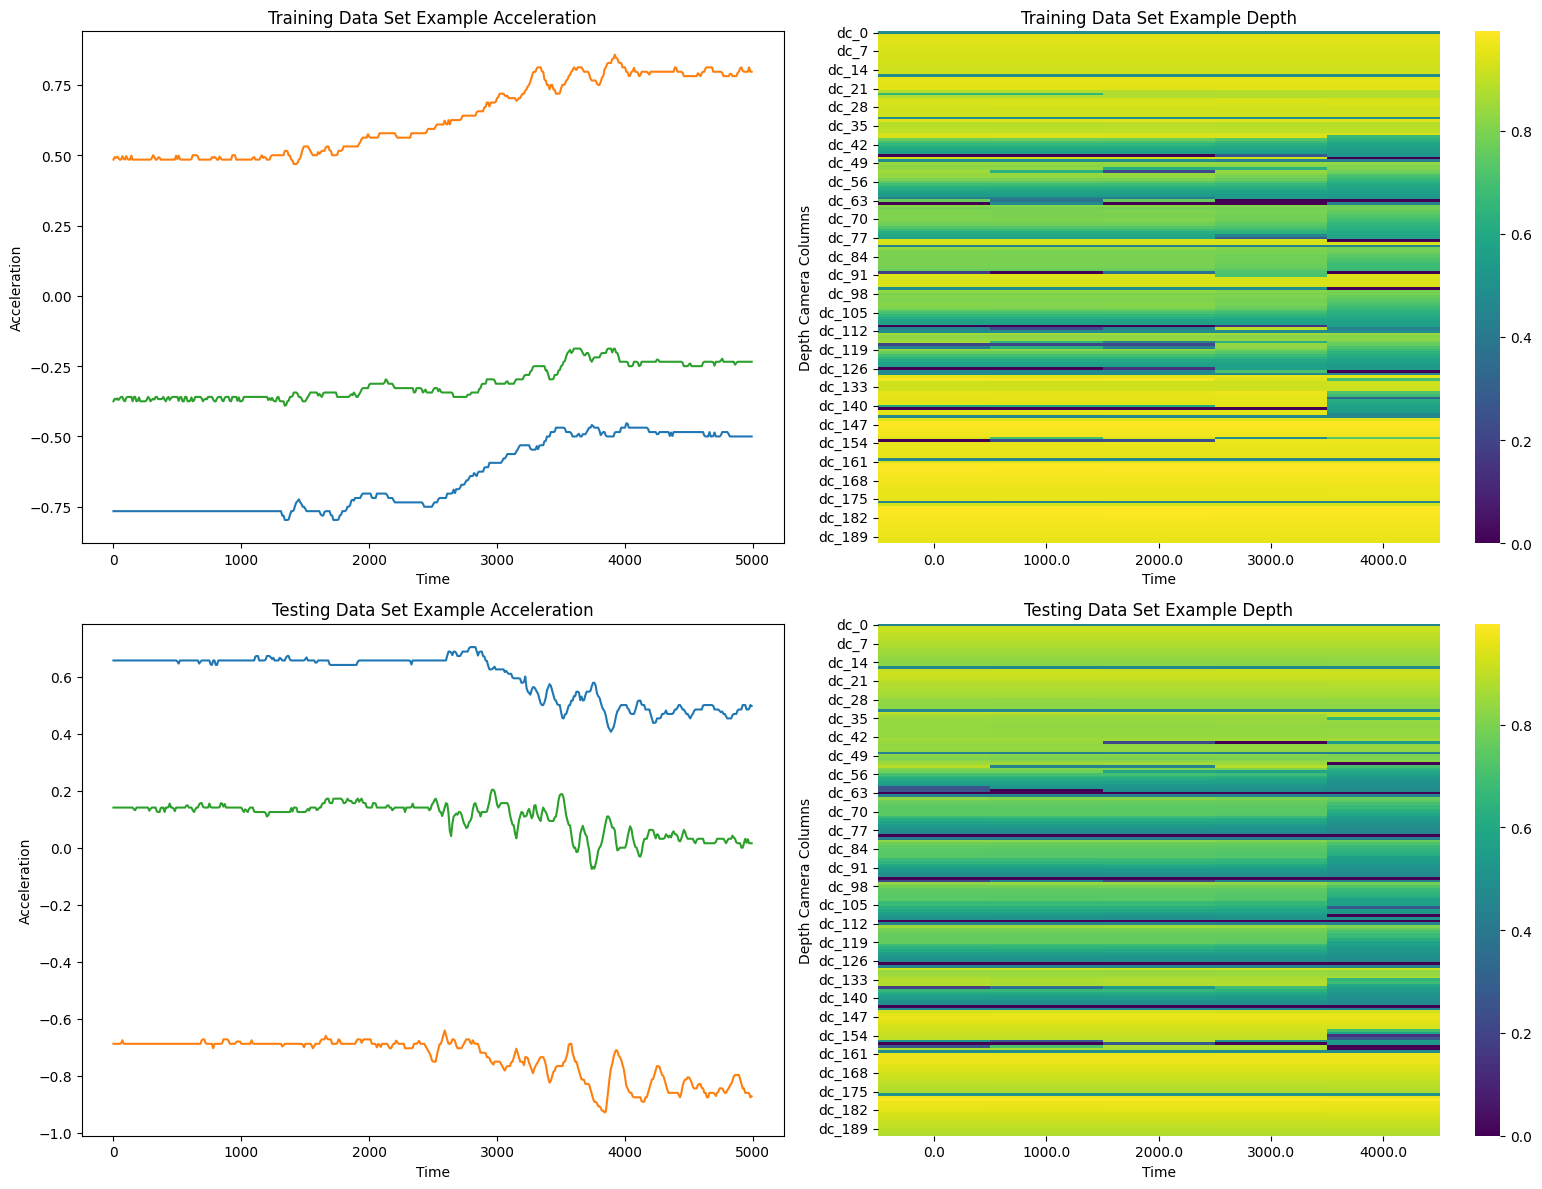

In [302]:
dfTrain_acceleration = merged_Training["df_Acc"].iloc[0]
dfTrain_depth = merged_Training["df_Dc"].iloc[0]

dfTest_acceleration = merged_Testing["df_Acc"].iloc[0]
dfTest_depth = merged_Testing["df_Dc"].iloc[0]

fig, axs = plt.subplots(2, 2, figsize=(16, 6*2))
row = 0
axs[row,0].plot(dfTrain_acceleration['time'], dfTrain_acceleration['acc_0'])
axs[row,0].plot(dfTrain_acceleration['time'], dfTrain_acceleration['acc_1'])
axs[row,0].plot(dfTrain_acceleration['time'], dfTrain_acceleration['acc_2'])
axs[row,0].set_xlabel('Time')
axs[row,0].set_ylabel('Acceleration')
axs[row,0].set_title('Training Data Set Example Acceleration')


sns.heatmap(dfTrain_depth.set_index('time').T, cmap='viridis',ax=axs[row,1])
axs[row,1].set_title('Training Data Set Example Depth')
axs[row,1].set_xlabel('Time')
axs[row,1].set_ylabel('Depth Camera Columns')
        

row = 1
         
axs[row,0].plot(dfTest_acceleration['time'], dfTest_acceleration['acc_0'])
axs[row,0].plot(dfTest_acceleration['time'], dfTest_acceleration['acc_1'])
axs[row,0].plot(dfTest_acceleration['time'], dfTest_acceleration['acc_2'])
axs[row,0].set_xlabel('Time')
axs[row,0].set_ylabel('Acceleration')
axs[row,0].set_title('Testing Data Set Example Acceleration')


sns.heatmap(dfTest_depth.set_index('time').T, cmap='viridis',ax=axs[row,1])
axs[row,1].set_title('Testing Data Set Example Depth')
axs[row,1].set_xlabel('Time')
axs[row,1].set_ylabel('Depth Camera Columns')
plt.tight_layout()
plt.show()

dfAccTrain = merged_Training[['subject_id', 'exercise_id', 'trial', 'window_idx', 'df_Acc']].copy()
dfDcTrain = merged_Training[['subject_id', 'exercise_id', 'trial', 'window_idx', 'df_Dc']].copy()
dfAccTest = merged_Testing[['subject_id', 'exercise_id', 'trial', 'window_idx', 'df_Acc']].copy()
dfDcTest = merged_Testing[['subject_id', 'exercise_id', 'trial', 'window_idx', 'df_Dc']].copy()

# 2. Feature extraction and fusion for unimodal classification

<a id='task2'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 2.</b>

Use the training dataset prepared in task 1. to build models based on the combination of principal component analysis (PCA), linear discriminant analysis (LDA), and nearest neighbour (NN) classifier for each modality separately and evaluate the model on test dataset. Do the subtasks given as 
<br>
<br>
<p> <b>2.1</b> Calculate PCA and LDA transformations to reduce the dimensionality of accelerometer data (e.g., using scikit-learn implementations). Before transformations downsample data from 100 Hz to 25 Hz (using scipy.signal.resample) to get 125x3 matrix of data for each 5 sec window. You should also standardize the values to zero mean and unit variance before the transformations. Using training dataset, fit PCA with 5-dimensional subspace (i.e., choosing the 5 largest principal components) and fit LDA with 5-dimensional subspace. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 3x(5+5). Perform the fusion of PCA and LDA similar manner as presented in Lecture 3 (pages 24-25) using NN method. Evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>

Note: Standardize the data along each axis.
<br>

Document your work, evaluate the results, and analyse the outcomes (The expected F1 score for this task should generally fall within the range of 40 to 50)
    
</div>

In [303]:
# 2.1

### Your code begins here ###
from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import minmax_scale


scaler = StandardScaler()

def preProcessData(dfAcc):
    dfNew = pd.DataFrame()
    for index, row in dfAcc.iterrows():
        if 'time' in row['df_Acc'].columns:
            df1 = row['df_Acc'].drop('time', axis=1)
        else:
            df1 = row['df_Acc'].copy()
    
        rowResampled = signal.resample(df1, 125).T
        #print(rowResampled.shape, "rowSampled")
        rowNormed = scaler.fit_transform(rowResampled)
        dfNormed = pd.DataFrame(rowNormed)
        dfNormed.columns = dfNormed.columns.astype(str)
        dfNormed["exercise_id"] = row["exercise_id"]
        #print(dfNormed)
        dfNew = pd.concat([dfNew, dfNormed], ignore_index=True)
        #print(dfNew.shape)
        #break
    return dfNew

Downsampling helps to reduce the workload in the computation ensuring there is no data loss.
However for the accuracy this downsampling can cause an effect.

In [303]:
dfAccTrainProc = preProcessData(dfAccTrain)
dfAccTestProc = preProcessData(dfAccTest)

dfAccTrainProc1 = dfAccTrainProc.drop('exercise_id', axis=1)
dfAccTestProc1 = dfAccTestProc.drop('exercise_id', axis=1)

pca = PCA(n_components = 5)

pcaTrain = pca.fit_transform(dfAccTrainProc1)
components = pca.components_
pcaTest = pca.transform(dfAccTestProc1)

lda = LinearDiscriminantAnalysis(n_components = 5)
ldaTrain = lda.fit_transform(dfAccTrainProc1, dfAccTrainProc['exercise_id'])
ldaTest = lda.transform(dfAccTestProc1)


def fusionofAccSensors(accDat):
    out = []
    for i in range(int(accDat.shape[0]/3)):
        windowDat = accDat[i*3:i*3+3]
        windowDat1 = windowDat.reshape(1, -1)
        #print(windowDat1[0])
        out.append(list(windowDat1[0]))
        #break
    return out

pcaFusedTrain = fusionofAccSensors(pcaTrain)
pcaFusedTest = fusionofAccSensors(pcaTest)

ldaFusedTrain = fusionofAccSensors(ldaTrain)
ldaFusedTest = fusionofAccSensors(ldaTest)

By leveraging classifications from both PCA and LDA the fusion provides more accurate results.

F1 score:  0.38590630463951797
Confusion matrix: 



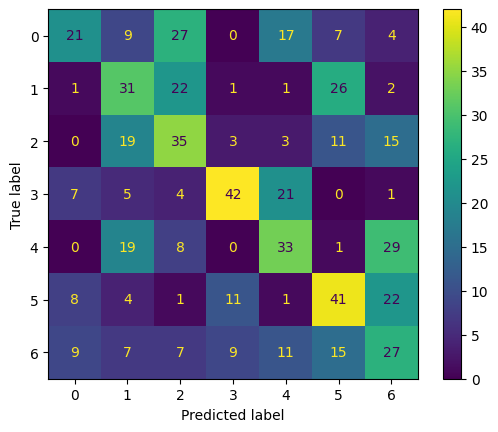

In [303]:
def euclidCompute(trainData, testData):
    out = []
    for testDind in testData:
        Dn = np.sum(np.power(np.array(testDind) - np.array(trainData), 2),axis = 1)
        out.append(Dn)
    return out

euclid_pca = euclidCompute(pcaFusedTrain, pcaFusedTest)
euclid_lda = euclidCompute(ldaFusedTrain, ldaFusedTest)


standardPCA = pd.DataFrame(minmax_scale(euclid_pca, feature_range=(0, 1), axis= 1, copy=True))
standardLDA = pd.DataFrame(minmax_scale(euclid_lda, feature_range=(0, 1), axis= 1, copy=True))

fusedLDAPCA = (standardPCA + standardLDA) / 2


dfLabel = pd.DataFrame()
dfTarget = pd.DataFrame()

for index, row in fusedLDAPCA.iterrows():
    
    argMinIndex = np.argmin(row)
    
    dfTrainLabel = pd.DataFrame([dfAccTrain['exercise_id'].iloc[argMinIndex]])
    dfTestLabel = pd.DataFrame([dfAccTest['exercise_id'].iloc[index]])
    
    dfTarget = pd.concat([dfTarget,dfTrainLabel],ignore_index=True)
    dfLabel = pd.concat([dfLabel,dfTestLabel],ignore_index=True)

print("F1 score: ", metrics.f1_score(dfLabel, dfTarget,average='weighted'))
print("Confusion matrix: \n", )
cm = metrics.confusion_matrix(dfLabel, dfTarget)
metrics.ConfusionMatrixDisplay(cm).plot()

### Your code ends here ###

The F1 score obtained here does not meet the base requirements given in the task.
I could not find any issues in the algorithm but I suspect a better way of implementing PCA for a moving window and collecting feature vectors could result in improved results.  However based on the instructions given the size of the moving windows are not needed. 

<a id='task2'></a>
<div class=" alert alert-warning">
<p> <b>2.2</b> Use PCA and LDA transformations to reduce the dimensionality of depth images. You should also standardize the values to zero mean and unit variance before the transformations. Fit PCA and LDA for all training images (12x16, 192-dimensional in vectorized form) by choosing 5-dimensional subspace for both PCA and LDA. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 5x1x(5+5). Similar to task 2.1, do the PCA and LDA fusion using NN and evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>

Note: Standardize the data along each axis.
<br>

Document your work, evaluate the results, and analyse the outcomes (The expected F1 score for this task should generally fall within the range of 40 to 50)
    
</div>

F1 score is  0.42455926372869796


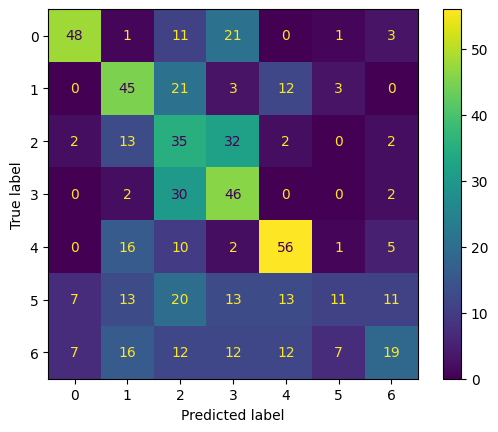

In [307]:
# 2.2
### Your code begins here ###

scaler = StandardScaler()

def preProcessData_DC(dfAcc):
    dfNew = pd.DataFrame()
    for index, row in dfAcc.iterrows():
        if 'time' in row['df_Dc'].columns:
            df1 = row['df_Dc'].drop('time', axis=1)
        else:
            df1 = row['df_Dc'].copy()
        rowNormed = scaler.fit_transform(df1)
        dfNormed = pd.DataFrame(rowNormed)
        dfNormed.columns = dfNormed.columns.astype(str)
        dfNormed["exercise_id"] = row["exercise_id"]
        #print(dfNormed)
        dfNew = pd.concat([dfNew, dfNormed], ignore_index=True)
        #print(dfNew.shape)
        #break
    return dfNew


dfDCTrainProc = preProcessData_DC(dfDcTrain)
dfDCTestProc = preProcessData_DC(dfDcTest)


dfDCTrainProc1 = dfDCTrainProc.drop('exercise_id', axis=1)
dfDCTestProc1 = dfDCTestProc.drop('exercise_id', axis=1)

pca = PCA(n_components = 5)

pcaTrain = pca.fit_transform(dfDCTrainProc1)
components = pca.components_
pcaTest = pca.transform(dfDCTestProc1)

lda = LinearDiscriminantAnalysis(n_components = 5)
ldaTrain = lda.fit_transform(dfDCTrainProc1, dfDCTrainProc['exercise_id'])
ldaTest = lda.transform(dfDCTestProc1)


def fusionofDCSequence(DCDat):
    out = []
    for i in range(int(DCDat.shape[0]/5)):
        windowDat = DCDat[i*5:i*5+5]
        windowDat1 = windowDat.reshape(1, -1)
        #print(windowDat1[0])
        out.append(list(windowDat1[0]))
        #break
    return out

pcaFusedTrain = fusionofDCSequence(pcaTrain)
pcaFusedTest = fusionofDCSequence(pcaTest)

ldaFusedTrain = fusionofDCSequence(ldaTrain)
ldaFusedTest = fusionofDCSequence(ldaTest)

euclid_pca = euclidCompute(pcaFusedTrain, pcaFusedTest)
euclid_lda = euclidCompute(ldaFusedTrain, ldaFusedTest)


standardPCA = pd.DataFrame(minmax_scale(euclid_pca, feature_range=(0, 1), axis= 1, copy=True))
standardLDA = pd.DataFrame(minmax_scale(euclid_lda, feature_range=(0, 1), axis= 1, copy=True))

fusedLDAPCA = (standardPCA + standardLDA) / 2


dfLabelDC = pd.DataFrame()
dfTargetDC = pd.DataFrame()

for index, row in fusedLDAPCA.iterrows():
    
    argMinIndex = np.argmin(row)
    
    dfTrainLabel = pd.DataFrame([dfDcTrain['exercise_id'].iloc[argMinIndex]])
    dfTestLabel = pd.DataFrame([dfDcTest['exercise_id'].iloc[index]])
    
    dfTargetDC = pd.concat([dfTargetDC,dfTrainLabel],ignore_index=True)
    dfLabelDC = pd.concat([dfLabelDC,dfTestLabel],ignore_index=True)

f1Score = metrics.f1_score(dfLabelDC, dfTargetDC,average='weighted')
print("F1 score is ", str(f1Score) )

cm = metrics.confusion_matrix(dfLabelDC, dfTargetDC)
metrics.ConfusionMatrixDisplay(cm).plot()
### Your code ends here ###


# 3. Feature extraction and feature-level fusion for multimodal classification

<a id='task3'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 3.</b>

Prepare new feature sets for each modality and combine them to single feature representation. Compare two classifiers from scikit-learn. Train classifiers using joint feature presentation. Evaluate and compare the result using testing dataset. Do the subtasks given as 
<br>   

<p> <b>3.1</b> Similar to task 2.1, calculate PCA for accelerometer, but choose now the 10 largest principal components as 10-dim feature vector for each window. In addition, for each window calculate mean and standard deviation of each three acc channels as statistical features, resulting 6-dimensional vector. Combine these to 36-dimensional final feature vector.</p>

Document your work.
    
</div>

In [334]:
# 3.1

### Your code begins here ###

#dfAccTrainProc = preProcessData(dfAccTrain)
#dfAccTestProc = preProcessData(dfAccTest)
#dfAccTrainProc1 = dfAccTrainProc.drop('exercise_id', axis=1)
#dfAccTestProc1 = dfAccTestProc.drop('exercise_id', axis=1)
#dfDCTrainProc = preProcessData_DC(dfDcTrain)
#dfDCTestProc = preProcessData_DC(dfDcTest)
#dfDCTrainProc1 = dfDCTrainProc.drop('exercise_id', axis=1)
#dfDCTestProc1 = dfDCTestProc.drop('exercise_id', axis=1)

pca = PCA(n_components = 10)
pcaTrain = pca.fit_transform(dfAccTrainProc1)
components = pca.components_
pcaTest = pca.transform(dfAccTestProc1)


AccMeanTrain = np.mean(dfAccTrainProc1, axis=1)
AccSTDTrain = np.std(dfAccTrainProc1, axis=1)
pcaTrain1 = np.concatenate((pcaTrain1[:, :-1], AccMeanTrain.values[:, None], pcaTrain1[:, -1:]), axis=1)
pcaTrain1 = np.concatenate((pcaTrain1[:, :-1], AccSTDTrain.values[:, None], pcaTrain1[:, -1:]), axis=1)

AccMeanTest = np.mean(dfAccTestProc1, axis=1)
AccSTDTest = np.std(dfAccTestProc1, axis=1)
pcaTest1 = np.concatenate((pcaTest1[:, :-1], AccMeanTest.values[:, None], pcaTest1[:, -1:]), axis=1)
pcaTest1 = np.concatenate((pcaTest1[:, :-1], AccSTDTest.values[:, None], pcaTest1[:, -1:]), axis=1)


pcaFusedTrain_ACC = fusionofAccSensors(pcaTrain1)
pcaFusedTest_ACC = fusionofAccSensors(pcaTest1)

### Your code ends here ###

<a id='task3'></a>
<div class=" alert alert-warning">

<p> <b>3.2</b> Similar to task 2.2, calculate the PCA for depth images using same setup, but now choose the 10 largest principal components as feature vector. Concatenate the image sequence forming 50-dimensional feature vector from each windowed example.</p>

Document your work.
    
</div>

In [333]:
# 3.2

### Your code begins here ###
pca = PCA(n_components = 10)
pcaTrain = pca.fit_transform(dfDCTrainProc1)
components = pca.components_
pcaTest = pca.transform(dfDCTestProc1)


pcaFusedTrain_DC = fusionofDCSequence(pcaTrain)
pcaFusedTest_DC = fusionofDCSequence(pcaTest)
### Your code ends here ###

<a id='task3'></a>
<div class=" alert alert-warning">

<p> <b>3.3</b> Form a joint feature presentation of features extracted in 3.1 and 3.2, resulting 86-dimensional feature vector for each example. Normalize data between 0-1 using the training dataset. Use support vector machine (SVM) with RBF-kernel and Gaussian naiveBayes classifier (use default parameter values for both classifiers). Train the classifiers and evaluate and compare classifiers on testset using confusion matrices and F1 scores.</p>

Note: Normalize the data along each axis.
<br>

Document your work, evaluate the results, and analyse the outcomes. (The expected F1 score for this task should generally fall within the range of 55 to 70)
    
</div>

F1 score is  0.32568333224803675
F1 score is  0.1777934759880528


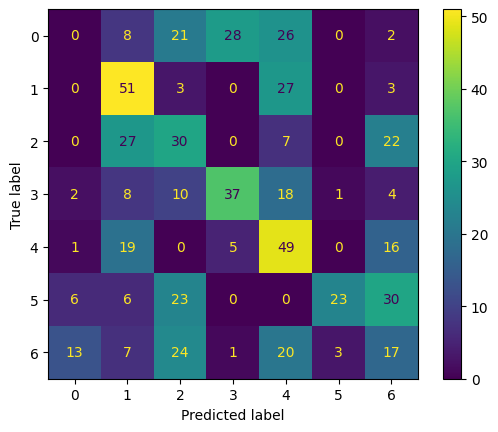

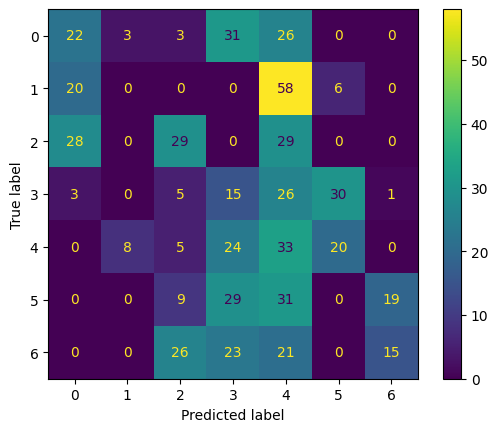

In [353]:
# 3.3

### Your code begins here ###

combPCATrain = [pcaFusedTrain_ACC[i] + pcaFusedTrain_DC[i] for i in range(len(pcaFusedTrain_ACC))]
combPCATest = [ pcaFusedTest_ACC[i] + pcaFusedTest_DC[i] for i in range(len(pcaFusedTest_ACC))]

combPCAStandardTrain = minmax_scale(combPCATrain, feature_range=(0, 1), axis=1, copy=True)
combPCAStandardTest = minmax_scale(combPCATest, feature_range=(0, 1), axis=1, copy=True)

# Setting up SVM classifier

from sklearn.svm import SVC
clf = SVC(kernel='rbf')
clf.fit(combPCAStandardTrain, merged_Training["exercise_id"])
#(1486, 86),  598
predLabels = clf.predict(combPCAStandardTest)

f1Score = metrics.f1_score(merged_Testing["exercise_id"], predLabels,average='weighted')
print("F1 score - SVM classifier is ", str(f1Score) )

cm = metrics.confusion_matrix(merged_Testing["exercise_id"], predLabels)
metrics.ConfusionMatrixDisplay(cm).plot()

# Setting up the Gaussian naiveBayes classifier
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(combPCAStandardTrain, np.ravel(merged_Training["exercise_id"]))

predictedLabelsGnB = gnb.predict(combPCAStandardTest)


f1Scoregnb = metrics.f1_score(merged_Testing["exercise_id"], predictedLabelsGnB,average='weighted')
print("F1 score - Gaussian naiveBayes is ", str(f1Scoregnb) )

cm = metrics.confusion_matrix(merged_Testing["exercise_id"],predictedLabelsGnB)
metrics.ConfusionMatrixDisplay(cm).plot()


### Your code ends here ###

# 4. Decision-level fusion for multimodal classification

<a id='task4'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 4.</b>

Use features calculated for each modality in task 3. Choose base classifier for each modality from scikit-learn. Train classifiers for each modality feature presentations separately and combine the outputs in decision level. Evaluate and compare the result on testing dataset. Do the subtasks given as 
<br>
<br> 
<p> <b>4.1</b> Use base classifiers of support vector machine (SVM) with RBF-kernel and AdaBoost classifier (with random_state=0). 
Normalize data between 0-1 using the training dataset. Train the base classifiers by tuning the model parameters (<i>C</i> parameter and RBF-kernel <i>gamma</i> in SVM as well as <i>n_estimators</i> and <i>learning_rate</i> in Adaboost) using 10-fold cross-validation on training dataset to find optimal set of parameters (hint: use GridSearchCV from scikit-learn). For grid search use the following values $C = [0.1, 1.0, 10.0, 100.0]$, $gamma=[0.1, 0.25, 0.5, 0.75, 1.0, 2.0]$, $n\_estimators = [50, 100, 500, 1000]$, and $learning\_rate = [0.1, 0.25, 0.5, 0.75,1.0]$.<br>
Choose the best parameters and train the classifiers for each modality on whole training dataset. Is there a possibility that classifiers will overfit to training data using this parameter selection strategy? If so, why? </p>

Note: Normalize the data along each axis.
<br>

Document your work, answer the given question, evaluate the results, and analyse the outcomes.
    
</div>

In [357]:
# 4.1

### Your code begins here ###
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
#pcaFusedTrain_ACC = fusionofAccSensors(pcaTrain1)
#pcaFusedTest_ACC = fusionofAccSensors(pcaTest1)
#pcaFusedTrain_DC = fusionofDCSequence(pcaTrain)
#pcaFusedTest_DC = fusionofDCSequence(pcaTest)

# Normalize the data along each axis.
pcaFusedTrainStd_ACC = minmax_scale(pcaFusedTrain_ACC, feature_range=(0, 1), axis=1, copy=True)
pcaFusedTestStd_ACC = minmax_scale(pcaFusedTest_ACC, feature_range=(0, 1), axis=1, copy=True)
pcaFusedTrainStd_DC = minmax_scale(pcaFusedTrain_DC, feature_range=(0, 1), axis=1, copy=True)
pcaFusedTestStd_DC = minmax_scale(pcaFusedTest_DC, feature_range=(0, 1), axis=1, copy=True)

# defining parameters and initializing all classifiers
trainingLabels = le.fit_transform(merged_Training["exercise_id"])
testingLabels = le.fit_transform(merged_Testing["exercise_id"])

svm_params = {
    'C': [0.1, 1.0, 10.0, 100.0],
    'gamma': [0.1, 0.25, 0.5, 0.75, 1.0, 2.0]
}

adaboost_params = {
    'n_estimators': [50, 100, 500, 1000],
    'learning_rate': [0.1, 0.25, 0.5, 0.75, 1.0]
}

## initiating SVM classifier
svm = SVC(kernel='rbf', probability=True, random_state=0)
adaboost = AdaBoostClassifier(random_state=0)

## assigning gridsearch settings
svm_grid_acc = GridSearchCV(svm, svm_params, cv=10, scoring='f1_macro')
svm_grid_dc = GridSearchCV(svm, svm_params, cv=10, scoring='f1_macro')
adaboost_grid_acc = GridSearchCV(adaboost, adaboost_params, cv=10, scoring='f1_macro')
adaboost_grid_dc = GridSearchCV(adaboost, adaboost_params, cv=10, scoring='f1_macro')


## Training process 
print("1- SVM Init")
svm_grid_acc.fit(pcaFusedTrainStd_ACC, trainingLabels)
svm_best_acc = svm_grid_acc.best_estimator_

svm_grid_dc.fit(pcaFusedTrainStd_DC, trainingLabels)
svm_best_dc = svm_grid_dc.best_estimator_

print("2- ADA init")
adaboost_grid_acc.fit(pcaFusedTrainStd_ACC, trainingLabels)
adaboost_best_acc = adaboost_grid_acc.best_estimator_

adaboost_grid_dc.fit(pcaFusedTrainStd_DC, trainingLabels)
adaboost_best_dc = adaboost_grid_dc.best_estimator_

### Your code ends here ###

1- SVM Init
2- ADA init


Yes, the selection of parameters can have an impact on the overfitting of the classifiers.
For example, the grid search parameters specified how to span in the search space. If the search space is too large there will be more correlation between the training data. Therefore resulting in overfitting. Therefore it is important to select these parameters carefully.

<a id='task4'></a>
<div class=" alert alert-warning">


<p> <b>4.2</b> Predict probabilistic outputs of each trained classifier for both modalities using the test set. </p>
<br>
Document your work, evaluate the results, and analyse the outcomes.
    
</div>

SVM classifier on Accelerometer data 0.035557414766785186
SVM classifier on Depth data 0.0337126000842815
ADA classifier on Accelerometer data 0.07797481834520585
ADA classifier on Depth Data 0.06611822059719684


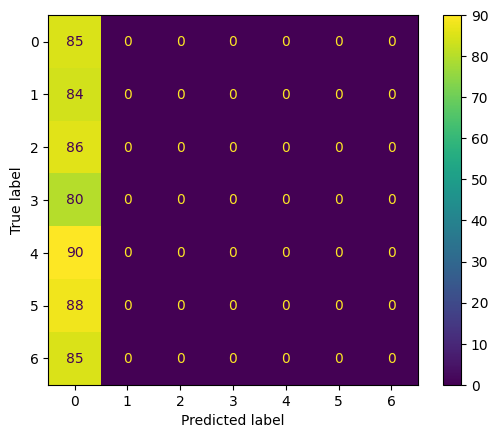

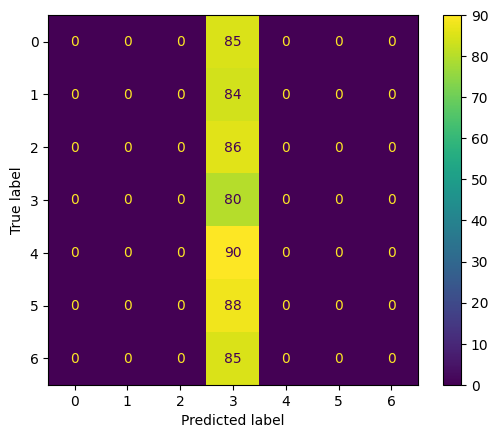

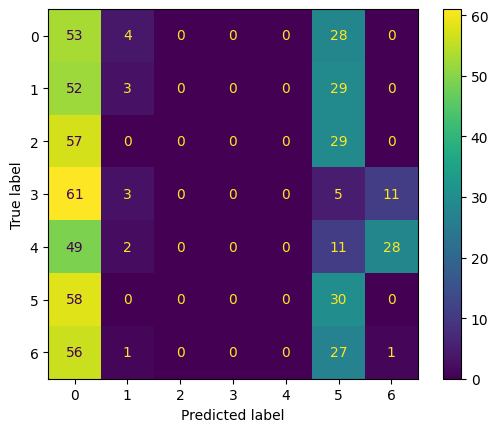

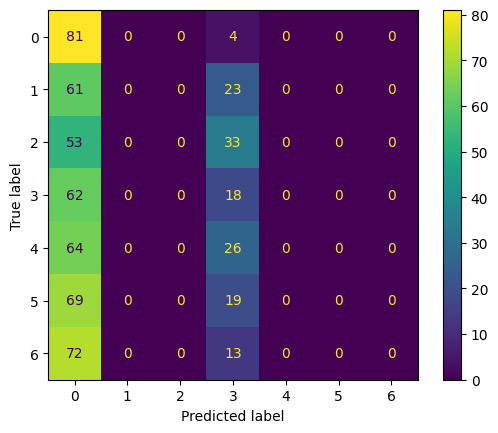

In [363]:
# 4.2

### Your code begins here ###

# calculating probabilities of each classifier for each modalities
prbACC_SVM = svm_best_acc.predict_proba(pcaFusedTest_ACC)
prbDC_SVM = svm_best_dc.predict_proba(pcaFusedTest_DC)
prbACC_ADA = adaboost_best_acc.predict_proba(pcaFusedTest_ACC)
prbDC_ADA = adaboost_best_dc.predict_proba(pcaFusedTest_DC)

# evaluating the performance of each classifier for each modalities

def documentofEval(test_labels,predictions):
    f1Score = metrics.f1_score(test_labels, predictions, average='macro')
    return f1Score

# SVM classifier on Accelerometer data
predACC_SVM = svm_best_acc.predict(pcaFusedTest_ACC)
f1ScoreACC_SVM = metrics.f1_score(testingLabels, predACC_SVM, average='macro')
print("SVM classifier on Accelerometer data", str(f1ScoreACC_SVM) )
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(testingLabels, predACC_SVM)).plot()


# SVM classifier on Depth data
predDC_SVM = svm_best_dc.predict(pcaFusedTest_DC)
f1ScoreDC_SVM = metrics.f1_score(testingLabels, predDC_SVM, average='macro')
print("SVM classifier on Depth data", str(f1ScoreDC_SVM) )
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(testingLabels, predDC_SVM)).plot()



# ADA classifier on Accelerometer data
predACC_ADA = adaboost_best_acc.predict(pcaFusedTest_ACC)
f1ScoreACC_ADA = metrics.f1_score(testingLabels, predACC_ADA, average='macro')
print("ADA classifier on Accelerometer data", str(f1ScoreACC_ADA) )
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(testingLabels, predACC_ADA)).plot()

# ADA classifier on Depth Data
predDC_ADA = adaboost_best_dc.predict(pcaFusedTest_DC)
f1ScoreDC_ADA = metrics.f1_score(testingLabels, predDC_ADA, average='macro')
print("ADA classifier on Depth Data", str(f1ScoreDC_ADA) )
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(testingLabels, predDC_ADA)).plot()

### Your code ends here ###

<a id='task4'></a>
<div class=" alert alert-warning">
<p> <b>4.3</b> Combine the probabilistic outputs of different modalities by fixed classification rules: max, min, prod, and sum. Evaluate, compare, and analyse the final combined results using confusion matrices and F1 scores. Show results for each base classifier combinations (i.e., $SVM_{acc}+SVM_{depth}$, $AdaBoost_{acc}+AdaBoost_{depth}$, $SVM_{acc}+AdaBoost_{depth}$, $AdaBoost_{acc}+SVM_{depth}$)</p>
<br>
Document your work, evaluate the results, and analyse the outcomes.
    
</div>

In [ ]:
# 4.3

### Your code begins here ###

### Your code ends here ###

# 5. Bonus task: Multimodal biometric identification of persons (optional)

<a id='task5'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 5.</b>

Can you build a classifier that recognizes the person who is performing the exercise? Use same 10 person dataset and split it so that first 25% of each long exercise sequence is used for training and rest 75% of each sequence is used for testing the classifier. Use same 5 second windowing with 3 seconds overlap to prepare the examples. Note that, now the person identity is the class label instead of exercise type. Max. 10 points are given but you can earn points from partial solution, as well.
<br> 
<br> 
<p> <b>5.1</b> Build a classifier to identify persons based on the features and one of the models given in task 4 (max. 5 points).</p>
<br> 
Document your work. Evaluate and compare the results using confusion matrix and F1 score.

</div>

In [ ]:
# 5.1

### Your code begins here ###

### Your code ends here ###

<a id='task5'></a>
<div class=" alert alert-warning">

<p> <b>5.2</b> Can you build your own solution (using new features, new classification model or different fusion approaches) to beat the approach in Task 5.1 ? (max. 5 points) </p>
<br>  
Document your work. Evaluate and compare the results using confusion matrix and F1 score.

</div>

In [ ]:
# 5.2

### Your code begins here ###

### Your code ends here ###